In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException

import time

In [17]:
url = 'https://today.yougov.com/ratings/entertainment/popularity/all-time-actors-actresses/all'
path = "Path" # Path to webdriver executable

chrome_options = Options()
chrome_options.binary_location = r"C:\Program Files\Google\Chrome\Application\chrome.exe"

# Use only chrome_options, not executable_path
driver = webdriver.Chrome(options=chrome_options)

driver.get(url)


# Decline cookies settings
try:
    decline_button = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, 'onetrust-reject-all-handler'))
    )

    decline_button.click()
except Exception as e:
    pass

# Scroll down to load more data
while True:
    # Scroll to the bottom of the page
    driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)

    # Wait for a short interval to allow the content to load
    time.sleep(2)

    # Check if there are more actors loaded
    try:
        load_more_button = WebDriverWait(driver, 100).until(
            EC.element_to_be_clickable((By.CLASS_NAME, 'load-more-button'))
        )
        
        load_more_button.click()
    except TimeoutException:
        break

html = driver.page_source
driver.quit()

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')

# Element containing the list of actors
actors_container = soup.find('div', class_='rankings-entities-list-container')

# Actor's list items
actor_items = actors_container.find_all('li', class_='ng-star-inserted')

# Create lists to store data
actor_names = []
popularity_percentages = []
fame_percentages = []

for actor_item in actor_items:
    # Extract the actor name
    actor_name = actor_item.find('img', class_='ng-star-inserted')['alt'] if actor_item.find('img', class_='ng-star-inserted') else None

    # Extract popularity percentage
    popularity_element = actor_item.find('span', class_='compact')
    popularity_percentage = popularity_element.text.split('%')[0] if popularity_element else None

    # Extract fame percentage
    fame_element = actor_item.find('span', class_='rankings-item-active')
    fame_percentage = fame_element.text.split('%')[0] if fame_element else None

    actor_names.append(actor_name)
    popularity_percentages.append(popularity_percentage)
    fame_percentages.append(fame_percentage)

data = {
    'Actor Name': actor_names,
    'Popularity (%)': popularity_percentages,
    'Fame (%)': fame_percentages
}

famous_actors = pd.DataFrame(data)

print(famous_actors)
famous_actors.to_csv('../Data/preprocessed_data/famous_actors_db.csv', index=False)


             Actor Name Popularity (%) Fame (%)
0        Morgan Freeman             98       86
1           Betty White             95       83
2        Robin Williams             96       83
3        Michael J. Fox             96       81
4     Denzel Washington             97       79
...                 ...            ...      ...
1495       Merve Dizdar             32       18
1496    Adriana Barraza             35       18
1497           Mohanlal             32       17
1498   Yalitza Aparicio             32       17
1499       Romain Duris             31       17

[1500 rows x 3 columns]


### 1. Find relationship between fame and popularity

In [21]:
actors_db = pd.read_csv('../Data/preprocessed_data/actors_db.csv')
famous_actors_db = pd.read_csv('../Data/preprocessed_data/famous_actors_db.csv')

In [27]:
# Merge DataFrames on actor name
merged_data = pd.merge(actors_db, famous_actors_db, left_on='name', right_on='Actor Name', how='inner')

# Check for missing values
print(merged_data.isnull().sum())

# Calculate the correlation coefficient
correlation_coefficient = merged_data['Popularity (%)'].corr(merged_data['popularity'], method='pearson')
print(f'Correlation Coefficient: {correlation_coefficient}')

name                 0
gender               0
popularity           0
original_language    0
genre_ids            0
known_for            0
id                   0
Actor Name           0
Popularity (%)       0
Fame (%)             0
dtype: int64
Correlation Coefficient: 0.21853557565634227


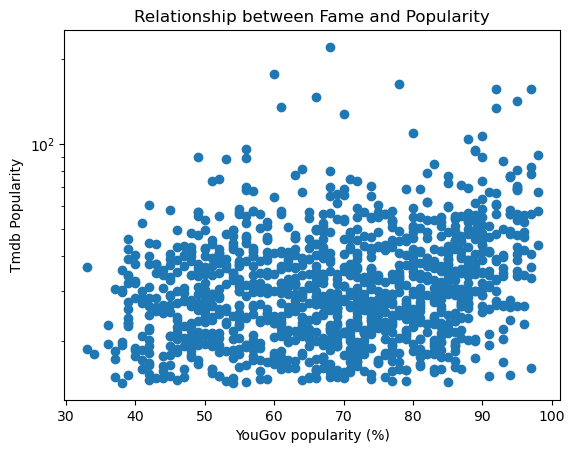

In [26]:
import matplotlib.pyplot as plt

# Not considered low
# Scatter plot
plt.scatter(merged_data['Popularity (%)'], merged_data['popularity'])
plt.xlabel('YouGov popularity (%)')
plt.ylabel('Tmdb Popularity')
plt.yscale('log')
plt.title('Relationship between Fame and Popularity')
plt.show()


Unfortunately, we cannot conclude a relationship between fame and popularity. We originally wanted to explore the relationship between fame and popularity for actors who have both features and determine if it's reasonable to extend the fame feature to other actors.  
But following the results we obtained, the correlation coefficient that is too weak (0.2) and the graph showing the relationship between both, we cannot conclude this latter.

## Movie trajectory for actors

In [3]:
# extract a json file and transform it into a dataframe
import requests
import pandas as pd
import json

tmdb_id2credit = json.load(open('../Data/tmdb_resources/tmdb_id2credit_full.json'))
id2credit_df = pd.DataFrame.from_dict(tmdb_id2credit, orient='index')
id2credit_df = id2credit_df.drop(columns='crew')

tmdb_id2credit_imdb_rating = json.load(open('../Data/tmdb_resources/tmdb_id2detail_imdb_rating.json'))
imdb_rating_df = pd.DataFrame.from_dict(tmdb_id2credit_imdb_rating, orient='index')

In [4]:
columns_to_keep = ['id', 'original_title', 'release_date', 'original_language', 'genres', 'budget', 'revenue', 'imdb_average_rating']
imdb_rating_filtered_df = imdb_rating_df[columns_to_keep]
imdb_rating_filtered_df.reset_index(drop=True, inplace=True)

# Creating a dataframe with revenue that is different from 0
revenue_non_zero_df = imdb_rating_filtered_df[imdb_rating_filtered_df['revenue'] != 0]
print(f'The number of movies with revenue is {revenue_non_zero_df.shape[0]:,}')

# Creating a dataframe with imdb_average_rating different from NaN
rating_not_nan_df = imdb_rating_filtered_df.dropna(subset=['imdb_average_rating'])
print(f'The number of movies with imdb ratings is {rating_not_nan_df.shape[0]:,}')

# Display the updated DataFrame
display(imdb_rating_filtered_df)

The number of movies with revenue is 18,904
The number of movies with imdb ratings is 393,909


,id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating
0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9
1,263493,The Gangsters,1913-05-29,en,"[{'id': 35, 'name': 'Comedy'}]",0,0,6.8
2,50944,The Sorcerer's Apprentice,2002-04-12,en,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",0,0,4.2
3,33592,White of the Eye,1987-06-19,en,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",0,0,6.1
4,43839,Alexander's Ragtime Band,1938-05-24,en,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",2000000,4000000,6.8
...,...,...,...,...,...,...,...,...
863077,1096279,Eva,2021-01-01,id,"[{'id': 99, 'name': 'Documentary'}]",0,0,NaN
863078,1001995,勾魂令,2018-02-02,zh,"[{'id': 27, 'name': 'Horror'}]",0,0,NaN
863079,823988,La Voix Humaine / L’Heure Espagnole,2021-03-26,en,[],0,0,NaN
863080,1022210,How Science Changed Our World,2010-12-23,en,"[{'id': 99, 'name': 'Documentary'}]",0,0,NaN


Cast preprocessing

In [5]:
# Assuming 'id' is the common column between imdb_rating_filtered_df and id2credits
merged_df = pd.merge(imdb_rating_filtered_df, id2credit_df, on='id', how='inner')

# Filter rows with either revenue not equal to 0 or imdb_average_rating not NaN
merged_df_filtered = merged_df[(merged_df['revenue'] != 0) | (~merged_df['imdb_average_rating'].isna())]
merged_df_filtered.reset_index(drop=True, inplace=True)
merged_df_filtered = merged_df_filtered.rename(columns={'id': 'movie_id'})


# Now, you can use merged_df_filtered for further analysis or display the desired information
print(f'The number of movies with revenue or imdb ratings is {merged_df_filtered.shape[0]:,}')
display(merged_df_filtered)

The number of movies with revenue or imdb ratings is 396,556


,movie_id,original_title,release_date,original_language,genres,budget,revenue,imdb_average_rating,cast
0,10016,Ghosts of Mars,2001-08-24,en,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",28000000,14010832,4.9,"[{'adult': False, 'gender': 1, 'id': 57395, 'k..."
1,263493,The Gangsters,1913-05-29,en,"[{'id': 35, 'name': 'Comedy'}]",0,0,6.8,"[{'adult': False, 'gender': 2, 'id': 1086663, ..."
2,50944,The Sorcerer's Apprentice,2002-04-12,en,"[{'id': 12, 'name': 'Adventure'}, {'id': 10751...",0,0,4.2,"[{'adult': False, 'gender': 1, 'id': 46948, 'k..."
3,33592,White of the Eye,1987-06-19,en,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",0,0,6.1,"[{'adult': False, 'gender': 2, 'id': 18181, 'k..."
4,43839,Alexander's Ragtime Band,1938-05-24,en,"[{'id': 18, 'name': 'Drama'}, {'id': 10402, 'n...",2000000,4000000,6.8,"[{'adult': False, 'gender': 2, 'id': 10922, 'k..."
...,...,...,...,...,...,...,...,...,...
396551,770135,Scandal in 97,2020-11-29,en,"[{'id': 53, 'name': 'Thriller'}]",0,0,4.9,"[{'adult': False, 'gender': 2, 'id': 1232652, ..."
396552,472471,Sniff!!!,2017-08-25,hi,"[{'id': 12, 'name': 'Adventure'}, {'id': 35, '...",0,0,5.3,"[{'adult': False, 'gender': 0, 'id': 1963881, ..."
396553,707790,マッハ’78,1978-02-25,ja,"[{'id': 28, 'name': 'Action'}]",0,0,6.1,"[{'adult': False, 'gender': 0, 'id': 2767640, ..."
396554,267899,El fuego inolvidable,2014-09-11,es,"[{'id': 18, 'name': 'Drama'}]",0,865,7.8,"[{'adult': False, 'gender': 2, 'id': 91251, 'k..."


In [6]:
import pandas as pd

def get_cast_dataframe(movie_id):
    cast = merged_df_filtered[merged_df_filtered['movie_id'] == movie_id]['cast'].values[0]
    #cast_df = pd.DataFrame(cast.tolist()).explode('cast', ignore_index=True)
    return cast

result_df = get_cast_dataframe(267899)
print(result_df)


[{'adult': False, 'gender': 2, 'id': 91251, 'known_for_department': 'Acting', 'name': 'Luis Fernando Peña', 'original_name': 'Luis Fernando Peña', 'popularity': 3.955, 'profile_path': '/1nooPX0s6Qi03Npt1Wr9AK7gE08.jpg', 'cast_id': 1, 'character': 'Francisco', 'credit_id': '5363fff80e0a261df800373d', 'order': 0}, {'adult': False, 'gender': 0, 'id': 1316106, 'known_for_department': 'Acting', 'name': 'Alejandra Guinea', 'original_name': 'Alejandra Guinea', 'popularity': 0.6, 'profile_path': None, 'cast_id': 2, 'character': 'Adela', 'credit_id': '536400090e0a261dfb003760', 'order': 1}, {'adult': False, 'gender': 0, 'id': 1316107, 'known_for_department': 'Acting', 'name': 'Mariana Urritia', 'original_name': 'Mariana Urritia', 'popularity': 0.6, 'profile_path': None, 'cast_id': 3, 'character': 'Xochitl', 'credit_id': '536400210e0a261dfb00376b', 'order': 2}, {'adult': False, 'gender': 0, 'id': 1316108, 'known_for_department': 'Acting', 'name': 'Francisco Cardoso', 'original_name': 'Francisco 

Movie detail has revenue and imdb ratings   
Movie credits has movie-actor pair data  

**Objective**: Given an actor's id, return a plot with an x axis of the movies they appread in sorted by year and a y axis of the movies' ratings.


In [19]:
def get_movies_by_actor(actor_id):
    """
    Retrieves a subset of movies from the DataFrame based on a specified actor_id,
    including the order of the actor in each movie.

    Parameters:
    - actor_id (int): The ID of the actor to filter movies by.

    Returns:
    - String: The name of the actor.
    - DataFrame: A subset of the original DataFrame containing only the movies
      where the specified actor is part of the cast, along with the 'order' column
      indicating the actor's order in each movie.
    """

    filtered_df = merged_df_filtered[
        merged_df_filtered['cast'].apply(
            lambda cast: any(
                actor_id == actor.get('id', '')
                for actor in cast
            )
        )
    ]
    filtered_df['order'] = filtered_df['cast'].apply(
        lambda cast: next(
            actor.get('order', '')
            for actor in cast
            if actor_id == actor.get('id', '')
        )
    )

    # set the indices to normal
    filtered_df.reset_index(drop=True, inplace=True)

    actor_name = filtered_df['cast'].apply(
        lambda cast: next(
            actor.get('name', '')
            for actor in cast
            if actor_id == actor.get('id', '')
        )
    ).values[0]
    return actor_name, filtered_df


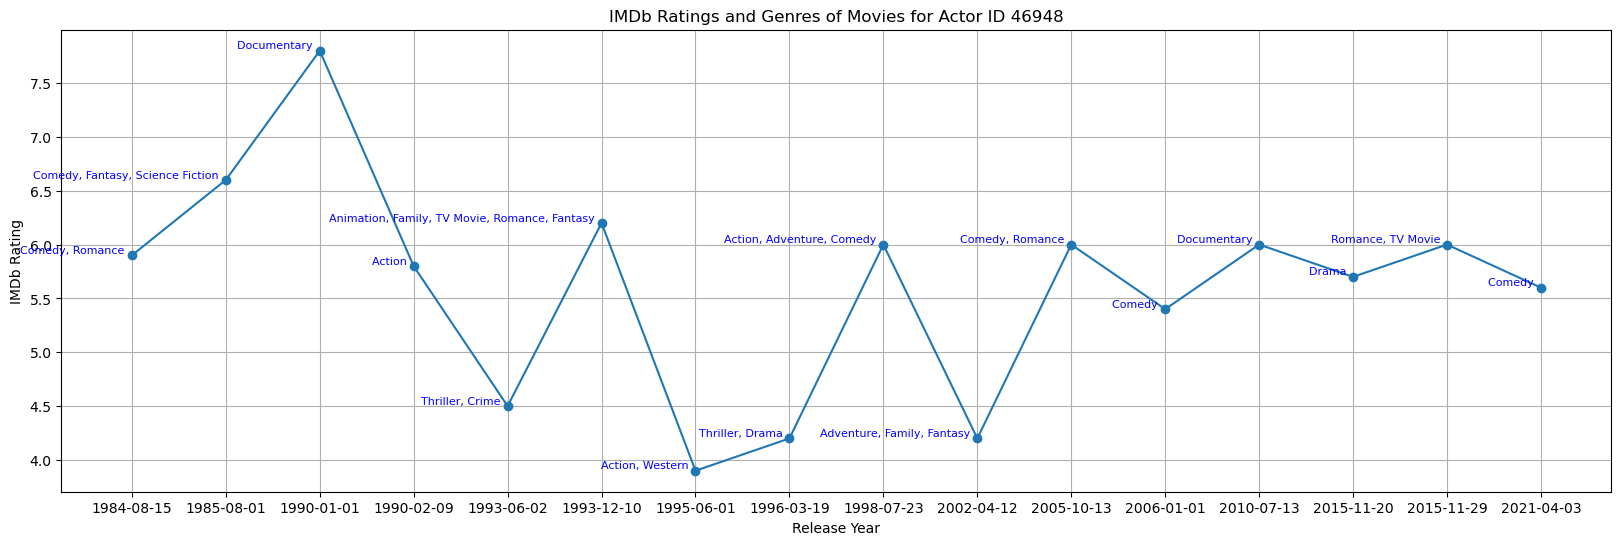

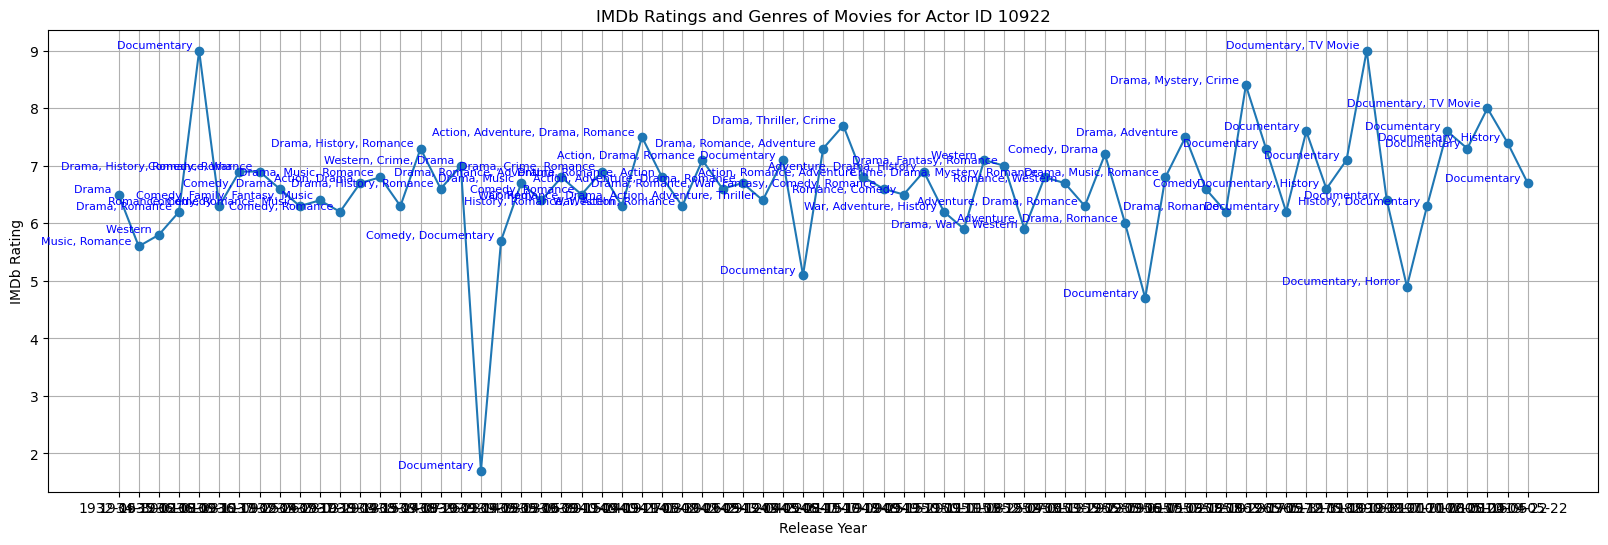

In [7]:
import pandas as pd
import json
import matplotlib.pyplot as plt

def get_movies_by_actor(actor_id):
    return merged_df_filtered[merged_df_filtered['cast'].apply(lambda cast: any(actor_id == actor.get('id', '') for actor in cast))]

def plot_movies_ratings(actor_id):
    actor_movies = get_movies_by_actor(actor_id)
    actor_movies_sorted = actor_movies.sort_values(by='release_date')

    plt.figure(figsize=(20, 6))
    plt.plot(actor_movies_sorted['release_date'], actor_movies_sorted['imdb_average_rating'], marker='o')
    
    # Add genre labels for each data point if genres exist
    for index, row in actor_movies_sorted.iterrows():
        if row['genres']:
            genres_str = ', '.join([genre['name'] for genre in row['genres']])
            plt.text(row['release_date'], row['imdb_average_rating'], f"\n{genres_str}  ", fontsize=8, ha='right', va='bottom', color='blue')

    plt.title(f'IMDb Ratings and Genres of Movies for Actor ID {actor_id}')
    plt.xlabel('Release Year')
    plt.ylabel('IMDb Rating')
    plt.grid(True)
    plt.show()

# Example: Plot movies for actor with id '46948'
plot_movies_ratings(46948)
plot_movies_ratings(10922)

In [21]:
import plotly.express as px

def plot_movies_ratings(actor_id):
    actor_name, actor_movies = get_movies_by_actor(actor_id)
    actor_movies_sorted = actor_movies.sort_values(by='release_date')

    # Convert 'genres' to a formatted string
    actor_movies_sorted['genres_str'] = actor_movies_sorted['genres'].apply(lambda genres: ', '.join([genre['name'] for genre in genres]) if genres else '')
    
    fig = px.scatter(actor_movies_sorted, x='release_date', y='imdb_average_rating',
                     hover_data=['original_title', 'genres_str', 'order'],
                     labels={'imdb_average_rating': 'IMDb Rating', 'release_date': 'Release Year', 'original_title': 'Movie name', 'genres_str': 'Genras', 'order': 'Order'},
                     title=f'IMDb Ratings and Genres of Movies for Actor {actor_name}',
                     color_discrete_sequence=['blue'])

    fig.show()

# Example: Plot movies for actor with id '10922'
plot_movies_ratings(1373737)

#budget, success of movie, types of roles
# divide timeline into 3 parts, 1st part is the beginning of the career, 2nd part is the middle of the career, 3rd part is the end of the career


C:\Users\anejj\AppData\Local\Temp\ipykernel_10780\3470819798.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [49]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

def divided_movies(actor_movies):
    num_movies = len(actor_movies)
    movies_per_part = num_movies // 3
    actor_movies_sorted = actor_movies.sort_values(by='release_date')

    first_part = actor_movies_sorted[:movies_per_part]
    second_part = actor_movies_sorted[movies_per_part:2 * movies_per_part]
    third_part = actor_movies_sorted[2 * movies_per_part:]

    return first_part['release_date'].max(), second_part['release_date'].max()

def plot_movies_ratings(actor_id):
    actor_name, actor_movies = get_movies_by_actor(actor_id)
    actor_movies_sorted = actor_movies.sort_values(by='release_date')

    # Determine dates at which the parts change
    date_beginning, date_middle = divided_movies(actor_movies)
    actor_movies_sorted['genres_str'] = actor_movies_sorted['genres'].apply(lambda genres: ', '.join([genre['name'] for genre in genres]) if genres else '')

    fig = px.scatter(actor_movies_sorted, x='release_date', y='imdb_average_rating',
                     hover_data=['original_title', 'genres_str', 'order'],
                     labels={'imdb_average_rating': 'IMDb Rating', 'release_date': 'Release Year', 'original_title': 'Movie name', 'genres_str': 'Genres', 'order': 'Order'},
                     title=f'IMDb Ratings and Genres of Movies for Actor {actor_name}',
                     color_discrete_sequence=['blue'])
    
    rgba_light_yellow = (255, 255, 153, 0.5)  # light yellow
    rgba_light_orange = (255, 165, 0, 0.5)    # light orange
    rgba_light_red = (240, 128, 128, 0.5)      # light red

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=actor_movies_sorted['release_date'].min(),
            x1=date_beginning,
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_yellow}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=date_beginning,
            x1=date_middle,
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_orange}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    fig.add_shape(
        go.layout.Shape(
            type="rect",
            x0=date_middle,
            x1=actor_movies_sorted['release_date'].max(),
            y0=0,
            y1=11,
            fillcolor=f"rgba{rgba_light_red}",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    )

    fig.show()

plot_movies_ratings(1373737)
plot_movies_ratings(10922)

C:\Users\anejj\AppData\Local\Temp\ipykernel_10780\3470819798.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\anejj\AppData\Local\Temp\ipykernel_10780\3470819798.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

